### Multilayer fully-connected network using the OverFeat features, with the following architecture:
* Input layer with the 4,096 OverFeat features.
* Hidden layer with 64 hidden units and ReLU activation.
* Output layer with 4 units (the four logits).

In [1]:
# Load and split the 5000 labeled data points into train, validation and test sets (3200, 800 and 1000 data points)

import numpy as np
import os

# Load the data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

pixels = cifar['pixels']
overfeat = cifar['overfeat']
labels = cifar['labels']
names = cifar['names']

# split the Overfeat data into train/test sets w/ same proportion of classes in each subset

import pandas as pd
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    overfeat, labels, train_size=4000, test_size=1000, 
    stratify=labels , # same class distribution
    random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

# Then, split the train set (4,000 points) into a (smaller) train and validation sets
# with respectively 3,200 and 800 samples

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, 
    stratify=y_tr , # same class distribution
    random_state=0)

print('Train2:', X_tr2.shape, y_tr2.shape)
print('Val:', X_val.shape, y_val.shape)
print('Class distribution in train set:','\n',pd.value_counts(y_tr2, normalize=True))
print('Class distribution in test set:','\n', pd.value_counts(y_val, normalize=True))

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)
Train2: (3200, 4096) (3200,)
Val: (800, 4096) (800,)
Class distribution in train set: 
 3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64
Class distribution in test set: 
 3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64


In [2]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [16]:
# Create multilayer network

import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Hidden layer with 64 hidden units and ReLU activation
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
            
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse = True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')
   
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse = True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')        
        
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)

    # Apply dropout
    inputs =tf.layers.dropout(
        X, rate=0.5, seed=0, training=training)
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=training)
        
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # L2 term
    l2_term_W1 = tf.nn.l2_loss(W1)
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha * (l2_term_W1 + l2_term_W2)
    
    # Training operation
    train_op = gd.minimize(loss)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [42]:
%%time
# Train network

# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(200):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_tr2, y_tr2, 256):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True, # Apply dropout
                alpha: 0.0001 # Regularization strength
            })

            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={X: X_te, y: y_te})
    
    print('Accuracy of our Network on the test set: {:.3f}'.format(test_acc))   
    print('Accuracy of our Network on the validation set: {:.3f}'.format(valid_acc))   

    # Weights of the hidden layer
    weights_hidden = W1.eval()
    weights_hidden = W2.eval()

Epoch 1 - valid: 0.470 train: 0.347 (mean)
Epoch 2 - valid: 0.565 train: 0.491 (mean)
Epoch 3 - valid: 0.623 train: 0.583 (mean)
Epoch 4 - valid: 0.673 train: 0.640 (mean)
Epoch 5 - valid: 0.685 train: 0.677 (mean)
Epoch 6 - valid: 0.689 train: 0.703 (mean)
Epoch 7 - valid: 0.717 train: 0.725 (mean)
Epoch 8 - valid: 0.723 train: 0.738 (mean)
Epoch 9 - valid: 0.734 train: 0.744 (mean)
Epoch 10 - valid: 0.735 train: 0.758 (mean)
Epoch 11 - valid: 0.745 train: 0.768 (mean)
Epoch 12 - valid: 0.744 train: 0.769 (mean)
Epoch 13 - valid: 0.746 train: 0.777 (mean)
Epoch 14 - valid: 0.746 train: 0.784 (mean)
Epoch 15 - valid: 0.751 train: 0.785 (mean)
Epoch 16 - valid: 0.757 train: 0.786 (mean)
Epoch 17 - valid: 0.755 train: 0.790 (mean)
Epoch 18 - valid: 0.762 train: 0.797 (mean)
Epoch 19 - valid: 0.765 train: 0.802 (mean)
Epoch 20 - valid: 0.765 train: 0.802 (mean)
Epoch 21 - valid: 0.769 train: 0.807 (mean)
Epoch 22 - valid: 0.772 train: 0.808 (mean)
Epoch 23 - valid: 0.769 train: 0.810 (mea

Epoch 186 - valid: 0.830 train: 0.881 (mean)
Epoch 187 - valid: 0.824 train: 0.882 (mean)
Epoch 188 - valid: 0.830 train: 0.879 (mean)
Epoch 189 - valid: 0.825 train: 0.887 (mean)
Epoch 190 - valid: 0.831 train: 0.886 (mean)
Epoch 191 - valid: 0.824 train: 0.884 (mean)
Epoch 192 - valid: 0.827 train: 0.883 (mean)
Epoch 193 - valid: 0.832 train: 0.883 (mean)
Epoch 194 - valid: 0.826 train: 0.883 (mean)
Epoch 195 - valid: 0.829 train: 0.886 (mean)
Epoch 196 - valid: 0.825 train: 0.885 (mean)
Epoch 197 - valid: 0.822 train: 0.886 (mean)
Epoch 198 - valid: 0.825 train: 0.886 (mean)
Epoch 199 - valid: 0.826 train: 0.884 (mean)
Epoch 200 - valid: 0.831 train: 0.885 (mean)
Accuracy of our Network on the test set: 0.816
Accuracy of our Network on the validation set: 0.831
CPU times: user 1min 46s, sys: 3.73 s, total: 1min 50s
Wall time: 39.2 s


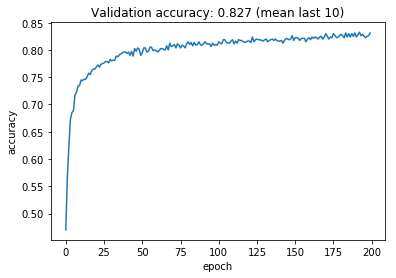

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 10)'.format(
    np.mean(valid_acc_values[-10:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

lr: 0.0001, alpha: 0.1 , val acc:0.76
lr: 0.001 , alpha: 0.01, val acc :0,827
lr: 0.001 , alpha: 0.001, val acc :0,827
lr: 0.001 , alpha: 0.0001, val acc :0,827
lr: 0.01 , alpha: 0.001, val acc :0,834 : but seems to overfit ?